In [1]:
import sys
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt             #visualisation
import seaborn as sns                       #visualisation
%matplotlib inline     
sns.set(color_codes=True)
import torch
from sklearn.model_selection import train_test_split
import pickle as pkl
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, classification_report, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


## Preprocessing the data:

In [2]:
def add_cell_prefix(df, prefix):
    df.index = [prefix + i for i in df.index]
    return df

#Remove extra quotes from the filenames
def extract_cell_name_smartseq(x):
    y = x.split("_")
    return y[len(y)-2]

def get_cell_name_smartseq(file_name):
    return extract_cell_name_smartseq(file_name)

def convert_indexes_to_cell_names_smartseq(df):
    df.index = [get_cell_name_smartseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_smartseq(df_meta, cell_name):
    return df_meta[df_meta["Cell name"]==cell_name]["Condition"].values[0]

def seperate_hypo_and_norm_smartseq(df, df_meta):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Hypo")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Norm" or get_cell_hypo_or_norm_smartseq(df_meta, x)=="Normo")]
    return df_hypo, df_norm

def process_df_smartseq(df, df_meta, prefix):
    df = convert_indexes_to_cell_names_smartseq(df)
    _, df_norm = seperate_hypo_and_norm_smartseq(df,df_meta)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

#Remove extra quotes from the filenames
def extract_cell_name_dropseq(x):
    y = x.split("_")
    return y[0]

def get_cell_name_dropseq(file_name):
    return extract_cell_name_dropseq(file_name)

def convert_indexes_to_cell_names_dropseq(df):
    df.index = [get_cell_name_dropseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_dropseq(cell_name):
    return cell_name.split("_")[-1]

def seperate_hypo_and_norm_dropseq(df):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Hypoxia")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Normoxia")]
    return df_hypo, df_norm

def process_df_dropseq(df, prefix):
    _, df_norm = seperate_hypo_and_norm_dropseq(df)
    df = convert_indexes_to_cell_names_dropseq(df)
    df_norm = convert_indexes_to_cell_names_dropseq(df_norm)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

In [3]:
mcf7_smartS_meta = pd.read_csv("Data/SmartSeq/MCF7_SmartS_MetaData.tsv",delimiter="\t", index_col=0)
mcf7_smartS_filn = pd.read_csv("Data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
hcc_smartS_meta = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_MetaData.tsv",delimiter="\t",index_col=0)
hcc_smartS_filn = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
mcf7_dropS_filn = pd.read_csv("Data/DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
hcc_dropS_filn = pd.read_csv("Data/DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T

In [4]:
mcf7_smartS_filn, mcf7_smartS_filn_idx = process_df_smartseq(mcf7_smartS_filn.copy(), mcf7_smartS_meta, "MCF7_")
hcc_smartS_filn, hcc_smartS_filn_idx = process_df_smartseq(hcc_smartS_filn.copy(), hcc_smartS_meta, "HCC1806_")
mcf7_dropS_filn, mcf7_dropS_filn_idx = process_df_dropseq(mcf7_dropS_filn, "MCF7_")
hcc_dropS_filn, hcc_dropS_filn_idx = process_df_dropseq(hcc_dropS_filn, "HCC1806_")

In [5]:
dataset_list = [mcf7_smartS_filn, hcc_smartS_filn, mcf7_dropS_filn, hcc_dropS_filn]
dataset_names = ["MCF7_SmartSeq", "HCC1806_SmartSeq", "MCF7_DropSeq", "HCC1806_DropSeq"]
datasets = dict(zip(dataset_names, dataset_list))
idx_datasets = dict(zip(dataset_names, [mcf7_smartS_filn_idx, hcc_smartS_filn_idx, mcf7_dropS_filn_idx, hcc_dropS_filn_idx]))
del dataset_list, dataset_names

In [6]:
# for each dataset in datasets, create a target column which is one if the index is in idx_datasets[dataset] and 0 otherwise
for name, df in datasets.items():
    df["target"] = df.index.map(lambda x: 1 if x in idx_datasets[name] else 0)

In [7]:
for name in datasets:
    print(f'Length of {name} dataset: {datasets[name].shape}')


Length of MCF7_SmartSeq dataset: (250, 3001)
Length of HCC1806_SmartSeq dataset: (182, 3001)
Length of MCF7_DropSeq dataset: (21626, 3001)
Length of HCC1806_DropSeq dataset: (14682, 3001)


&nbsp;

## Creating a general Pipeline:

In [8]:
def tune_model(X, y, params, pipeline, n_repeats=3, hyperparameter_tuner='grid', n_iter=None, verbose=1, sample_weights=None, probability=True, principal_metric='roc_auc', error_score=np.nan):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42)
    if probability:
        scoring = ['roc_auc', 'accuracy', 'f1', 'precision', 'recall']
    else: 
        scoring = ['accuracy', 'f1', 'precision', 'recall']
    principal_metric = principal_metric

    if hyperparameter_tuner == 'grid':
        search = GridSearchCV(pipeline, params, cv=cv, scoring=scoring, refit=principal_metric, n_jobs=-1, verbose=verbose, error_score=np.nan)
    elif hyperparameter_tuner == 'random':
        search = RandomizedSearchCV(pipeline, params, cv=cv, scoring=scoring, refit=principal_metric, n_iter=n_iter, n_jobs=-1, verbose=verbose, error_score=np.nan)
    elif hyperparameter_tuner == 'bayes':
        search = BayesSearchCV(pipeline, params, cv=cv, scoring=scoring, refit=principal_metric, n_iter=n_iter, n_jobs=-1, verbose=verbose, error_score=np.nan)
    else:
        raise ValueError(f"Unknown hyperparameter tuner: {hyperparameter_tuner}\n Choose from 'grid', 'random', 'bayes'")
    if sample_weights is not None:
        kwargs = {pipeline.steps[-1][0] + '__sample_weight': sample_weights}
        result = search.fit(X, y, **kwargs)
    else:
        result = search.fit(X, y)
    best_model = result.best_estimator_

    return result, best_model

In [9]:
def model_validation_performance(result, principal_metric='roc_auc',probability=True):
    print('')
    if probability:
        scoring = ['roc_auc', 'accuracy', 'f1', 'precision', 'recall']
    else: 
        scoring = ['accuracy', 'f1', 'precision', 'recall']
    # order the list such that the principal metric is the first element
    scoring.insert(0, scoring.pop(scoring.index(principal_metric)))
    for i in scoring:
        if i == principal_metric:
            print(f'Best {i} score: {result.best_score_}')
            print('')
        print(f"Cross-validation {i} scores: {result.cv_results_['mean_test_'+i][result.best_index_]}\n")
    print(f"\nParameters for the best model: \n{result.best_params_}")

In [10]:
def plot_results(result, principal_metric='roc_auc'):
    # Extract the results into a pandas DataFrame
    results = pd.DataFrame(result.cv_results_)
    
    # Extract parameter names
    param_names = [col for col in results.columns if col.startswith('param_')]
    
    # Create subplots for each parameter
    num_params = len(param_names)
    fig, axs = plt.subplots(num_params, 1, figsize=(10, num_params * 4))
    
    # Ensure axs is a 1D array
    if num_params == 1:
        axs = [axs]
    
    for i, param in enumerate(param_names):
        param_values = results[param]
        mean_test_score = results[f'mean_test_{principal_metric}']
        
        # Create a dataframe for table and compute average scores for unique parameter values
        table_data = pd.DataFrame({
            param: param_values,
            f'mean_test_{principal_metric}': mean_test_score,
        })

        # Sort parameter values correctly if they are numerical
        try:     
            table_data[param] =  table_data[param].fillna(-1)   
            table_data[param] = table_data[param].astype(float)
        except (TypeError, ValueError):
            table_data[param] = table_data[param].astype(str)
        
        grouped_data = table_data.groupby(param).agg({
            f'mean_test_{principal_metric}': list,
        }).reset_index()
        
        grouped_data = grouped_data.sort_values(by=param)     
        sorted_param_values = grouped_data[param].replace([-1, "-1"], "N/A")
        
        # Plot mean test score using boxplot
        sns.boxplot(x=sorted_param_values, y=grouped_data[f'mean_test_{principal_metric}'].explode(), ax=axs[i], color='#8EC6FF', width=0.8)
        axs[i].set_title(f'Mean {principal_metric} score of {param}')
        axs[i].set_xlabel(param)
        axs[i].set_ylabel(f'Mean {principal_metric} score')
        axs[i].tick_params(axis='x', rotation=20)
        axs[i].format_coord = lambda x,y: '%3d, %3d' % (x,y)
    
    plt.tight_layout()
    plt.show()

In [11]:
def model_test_performance(name, best_model, X_test, y_test, probability=True):
    print(f'Evaluating the performance on the test set for {name}:\n')
    y_pred = best_model.predict(X_test)
    if probability:
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f'ROC AUC: {roc_auc}')
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')
    print(f'F1: {f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

    # display confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    classes = ('Normoxia', 'Hypoxia')
    df_cm = pd.DataFrame(cm, index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    plt.title(f'Confusion matrix for {name}')
    plt.show()

In [12]:
# for each dataset we create a train-test split
X_train, X_test, y_train, y_test = {}, {}, {}, {}
for name, df in datasets.items():
    X = df.drop(columns=['target'])
    y = df['target']
    X_train[name], X_test[name], y_train[name], y_test[name] = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## XGBOOST:

We first run XGBOOST, a very popular and flexiblle ensemble learning technique based on decision trees 

In [13]:
from xgboost import XGBClassifier
import xgboost as xgb

In [14]:
def xgb_pipe_params(X, y, n_estimators=200, balance=True):
    # find total negative and positive samples 
    total = len(y)
    total_positive = np.sum(y==1)
    total_negative = total - total_positive

    # set the scale pos weight
    scale_pos_weight = total_negative / total_positive if balance else 1

    # Define the pipeline steps
    xgb_pipeline = Pipeline([
        ('xgb', XGBClassifier(scale_pos_weight=scale_pos_weight, n_estimators=n_estimators, device='cuda', n_jobs=-1, tree_method='hist'))  
    ])

    xgb_params = {
        'xgb__reg_alpha': [0.0, 1, 10, 100],
        'xgb__eta': [0.1, 0.3, 0.5],
        'xgb__colsample_bytree': [0.5, 1.0],
        'xgb__subsample': [0.5, 1.0],
        'xgb__colsample_bylevel': [0.5, 1.0]
    }

    return xgb_pipeline, xgb_params

In [ ]:
# Training the models
for name, df in datasets.items():
    print(f'Tuning {name} dataset')
    if (name == 'MCF7_SmartSeq'):
        continue
    if (name == 'MCF7_SmartSeq') or (name == 'HCC1806_SmartSeq'):
        n_estimators = 100
    else:
        n_estimators = 1000
    pipeline, params = xgb_pipe_params(X_train[name], y_train[name], n_estimators=n_estimators, balance=True)
    result, best_model = tune_model(X_train[name], y_train[name], params, pipeline, n_repeats=3, hyperparameter_tuner='grid', n_iter=100, verbose=10, probability=True, principal_metric='roc_auc', error_score=np.nan)

    # save the model and the result
    model_name = f'xgboost_mkII_{name}'
    with open(f'models/{model_name}.pkl', 'wb') as f:
        pkl.dump(best_model, f)

    result_name = f'xgboost_mkII_result_{name}'
    with open(f'results/{result_name}.pkl', 'wb') as f:
        pkl.dump(result, f)

Tuning MCF7_SmartSeq dataset
Tuning HCC1806_SmartSeq dataset
Fitting 15 folds for each of 96 candidates, totalling 1440 fits
Tuning MCF7_DropSeq dataset
Fitting 15 folds for each of 96 candidates, totalling 1440 fits


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Asus\AppData\Local\Temp\ipykernel_16744\16218594.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  table_data[param] =  table_data[param].fillna(-1)
C:\Users\Asus\AppData\Local\Temp\ipykernel_16744\16218594.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To o


Best roc_auc score: 1.0

Cross-validation roc_auc scores: 1.0

Cross-validation accuracy scores: 0.9933333333333334

Cross-validation f1 scores: 0.9931623931623932

Cross-validation precision scores: 1.0

Cross-validation recall scores: 0.9866666666666666


Parameters for the best model: 
{'xgb__colsample_bylevel': 0.5, 'xgb__colsample_bytree': 0.5, 'xgb__eta': 0.3, 'xgb__reg_alpha': 0.0, 'xgb__subsample': 0.5}


C:\Users\Asus\AppData\Local\Temp\ipykernel_16744\16218594.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  table_data[param] =  table_data[param].fillna(-1)
C:\Users\Asus\AppData\Local\Temp\ipykernel_16744\16218594.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  table_data[param] =  table_data[param].fillna(-1)


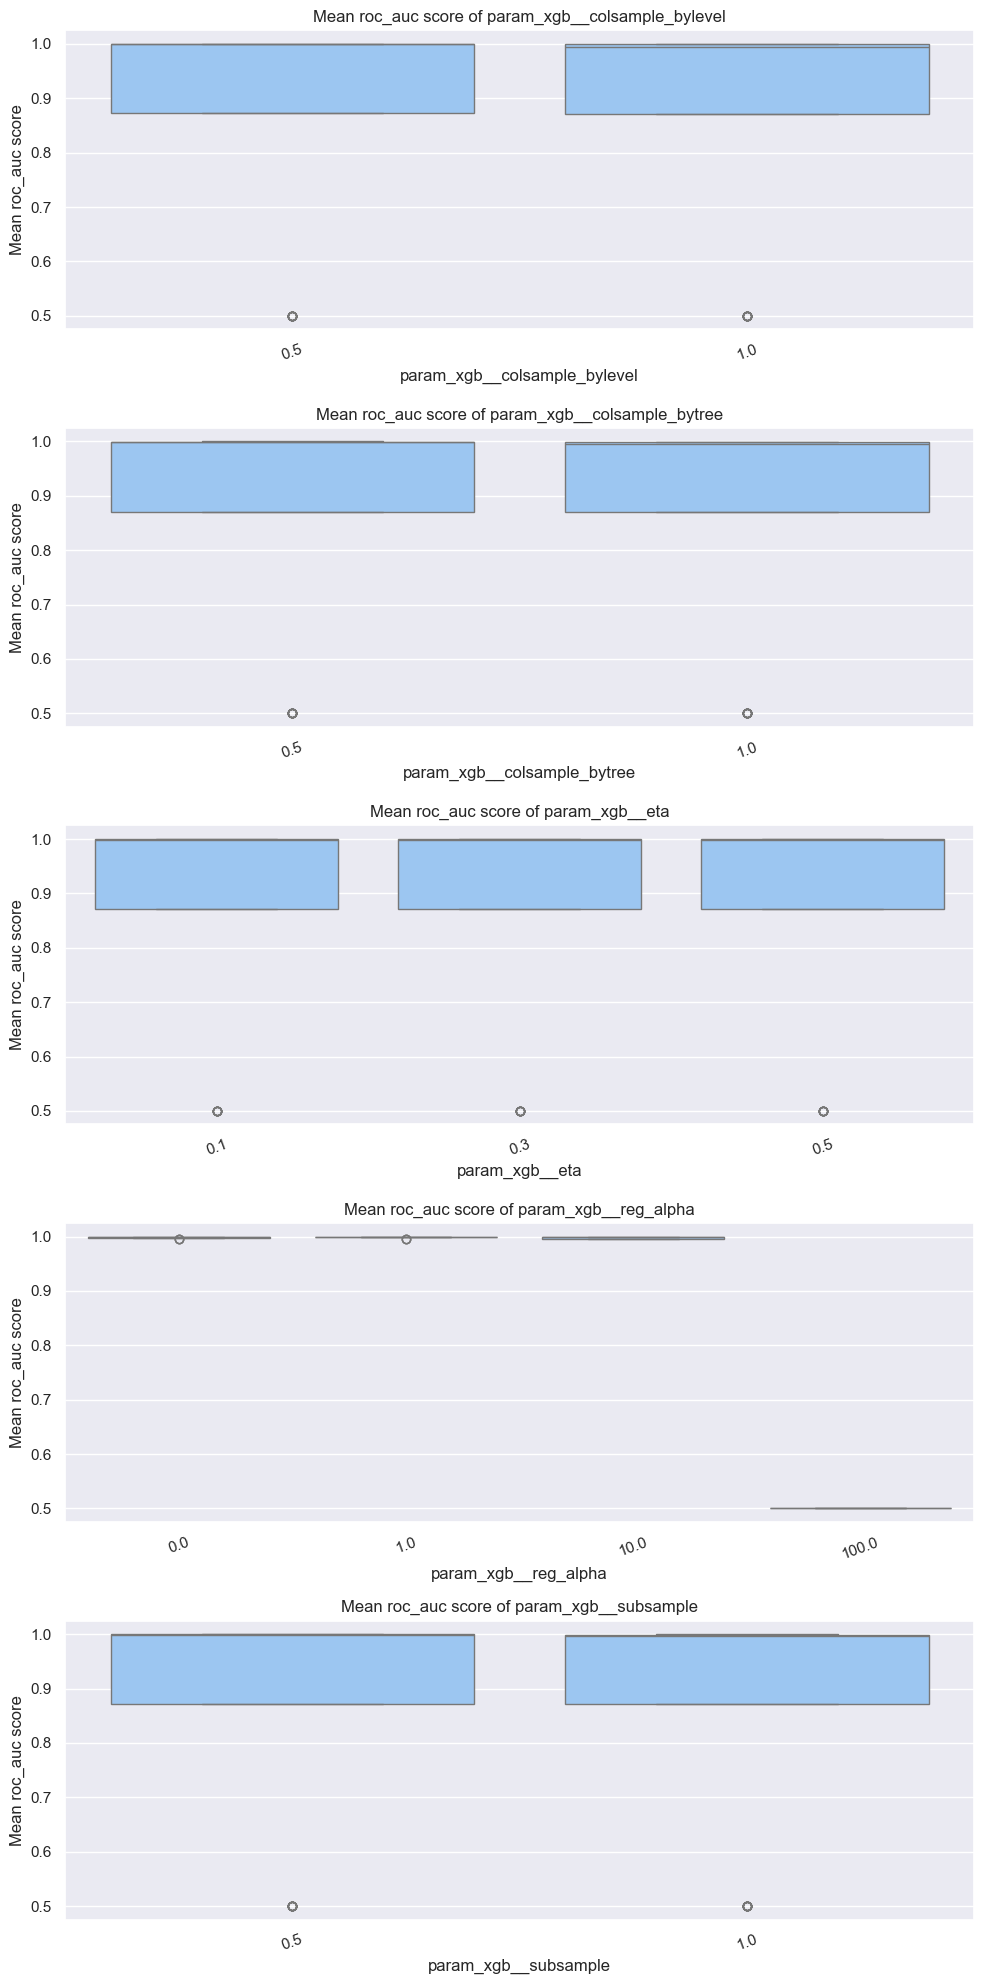


The training of MCF7_SmartSeq is done, saving the model


----------------------------------------------------------------------------------------------------

Best roc_auc score: 0.9971336996336996

Cross-validation roc_auc scores: 0.9971336996336996

Cross-validation accuracy scores: 0.9793103448275862

Cross-validation f1 scores: 0.9770540655598126

Cross-validation precision scores: 0.981904761904762

Cross-validation recall scores: 0.9747252747252748


Parameters for the best model: 
{'xgb__colsample_bylevel': 0.5, 'xgb__colsample_bytree': 0.5, 'xgb__eta': 0.3, 'xgb__reg_alpha': 0.0, 'xgb__subsample': 1.0}


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Asus\AppData\Local\Temp\ipykernel_16744\16218594.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in t

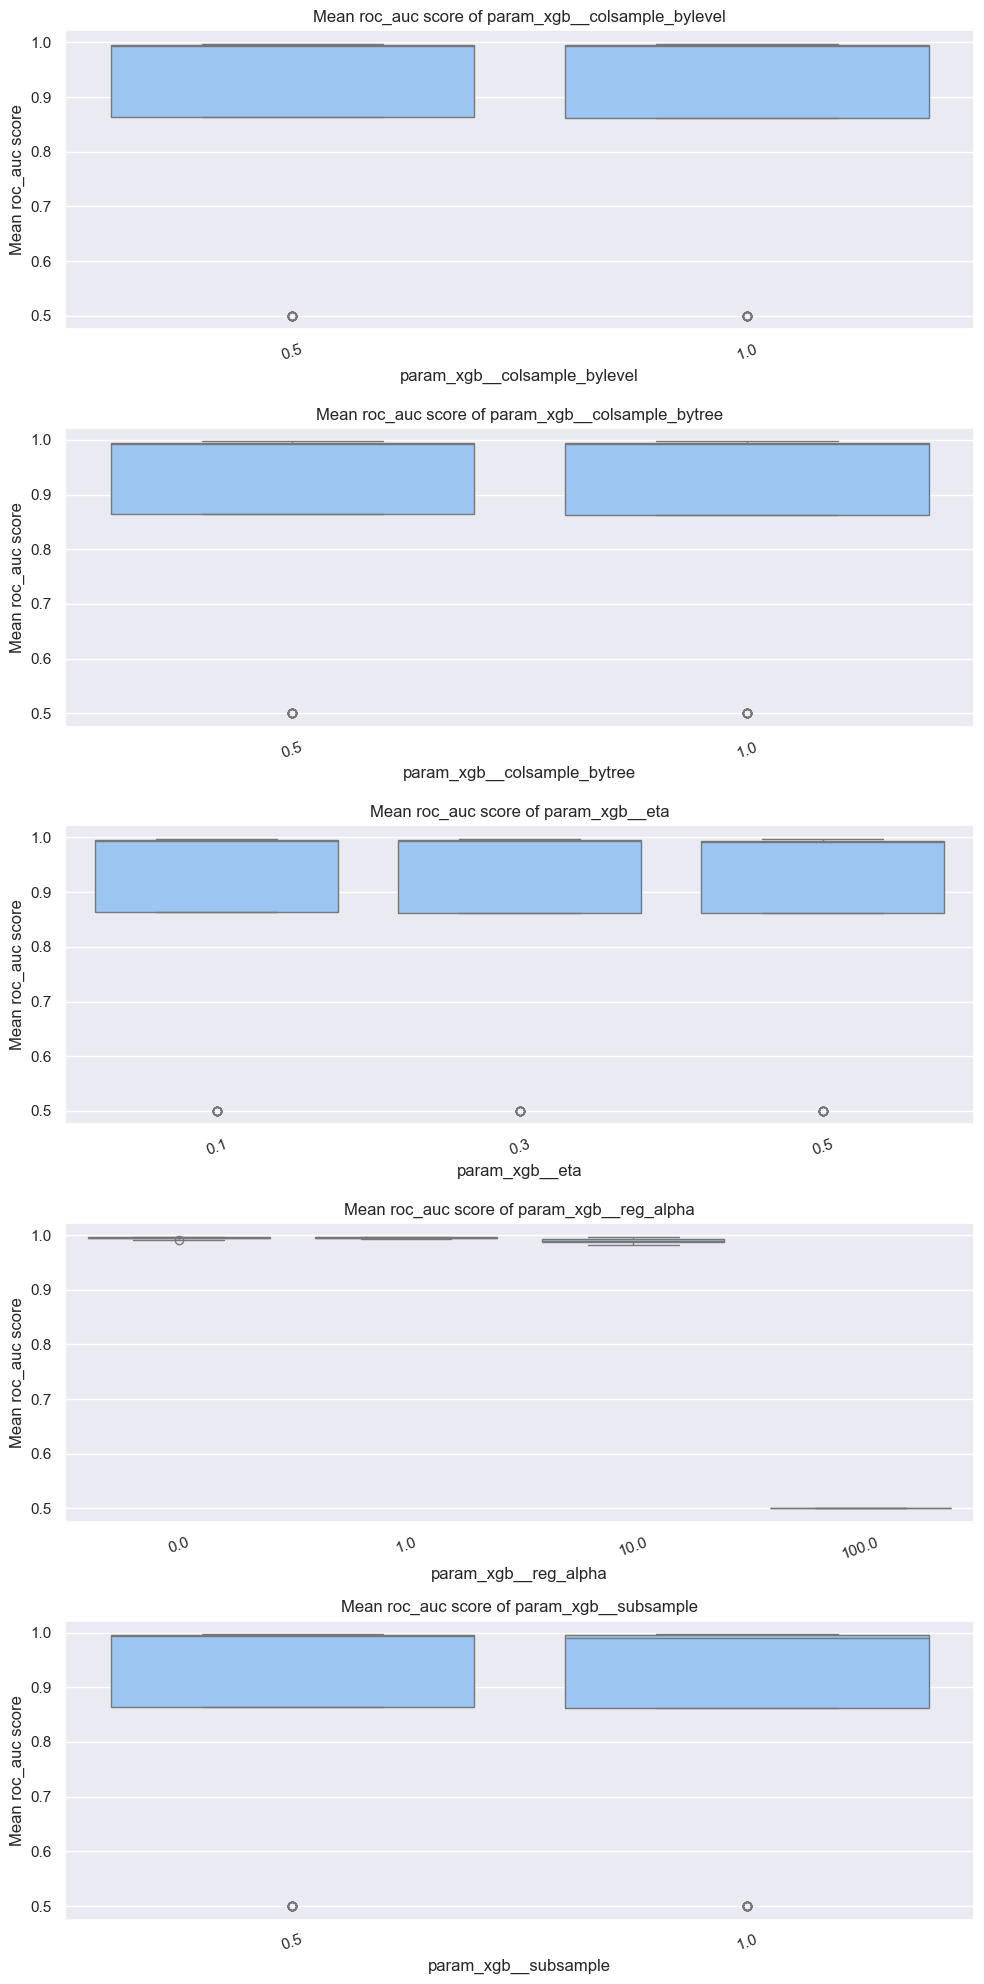


The training of HCC1806_SmartSeq is done, saving the model


----------------------------------------------------------------------------------------------------

Best roc_auc score: 0.9963725790585914

Cross-validation roc_auc scores: 0.9963725790585914

Cross-validation accuracy scores: 0.9816955684007708

Cross-validation f1 scores: 0.9845077768989937

Cross-validation precision scores: 0.984100096651031

Cross-validation recall scores: 0.9849241311796376


Parameters for the best model: 
{'xgb__colsample_bylevel': 0.5, 'xgb__colsample_bytree': 0.5, 'xgb__eta': 0.1, 'xgb__reg_alpha': 0.0, 'xgb__subsample': 1.0}


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Asus\AppData\Local\Temp\ipykernel_16744\16218594.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in t

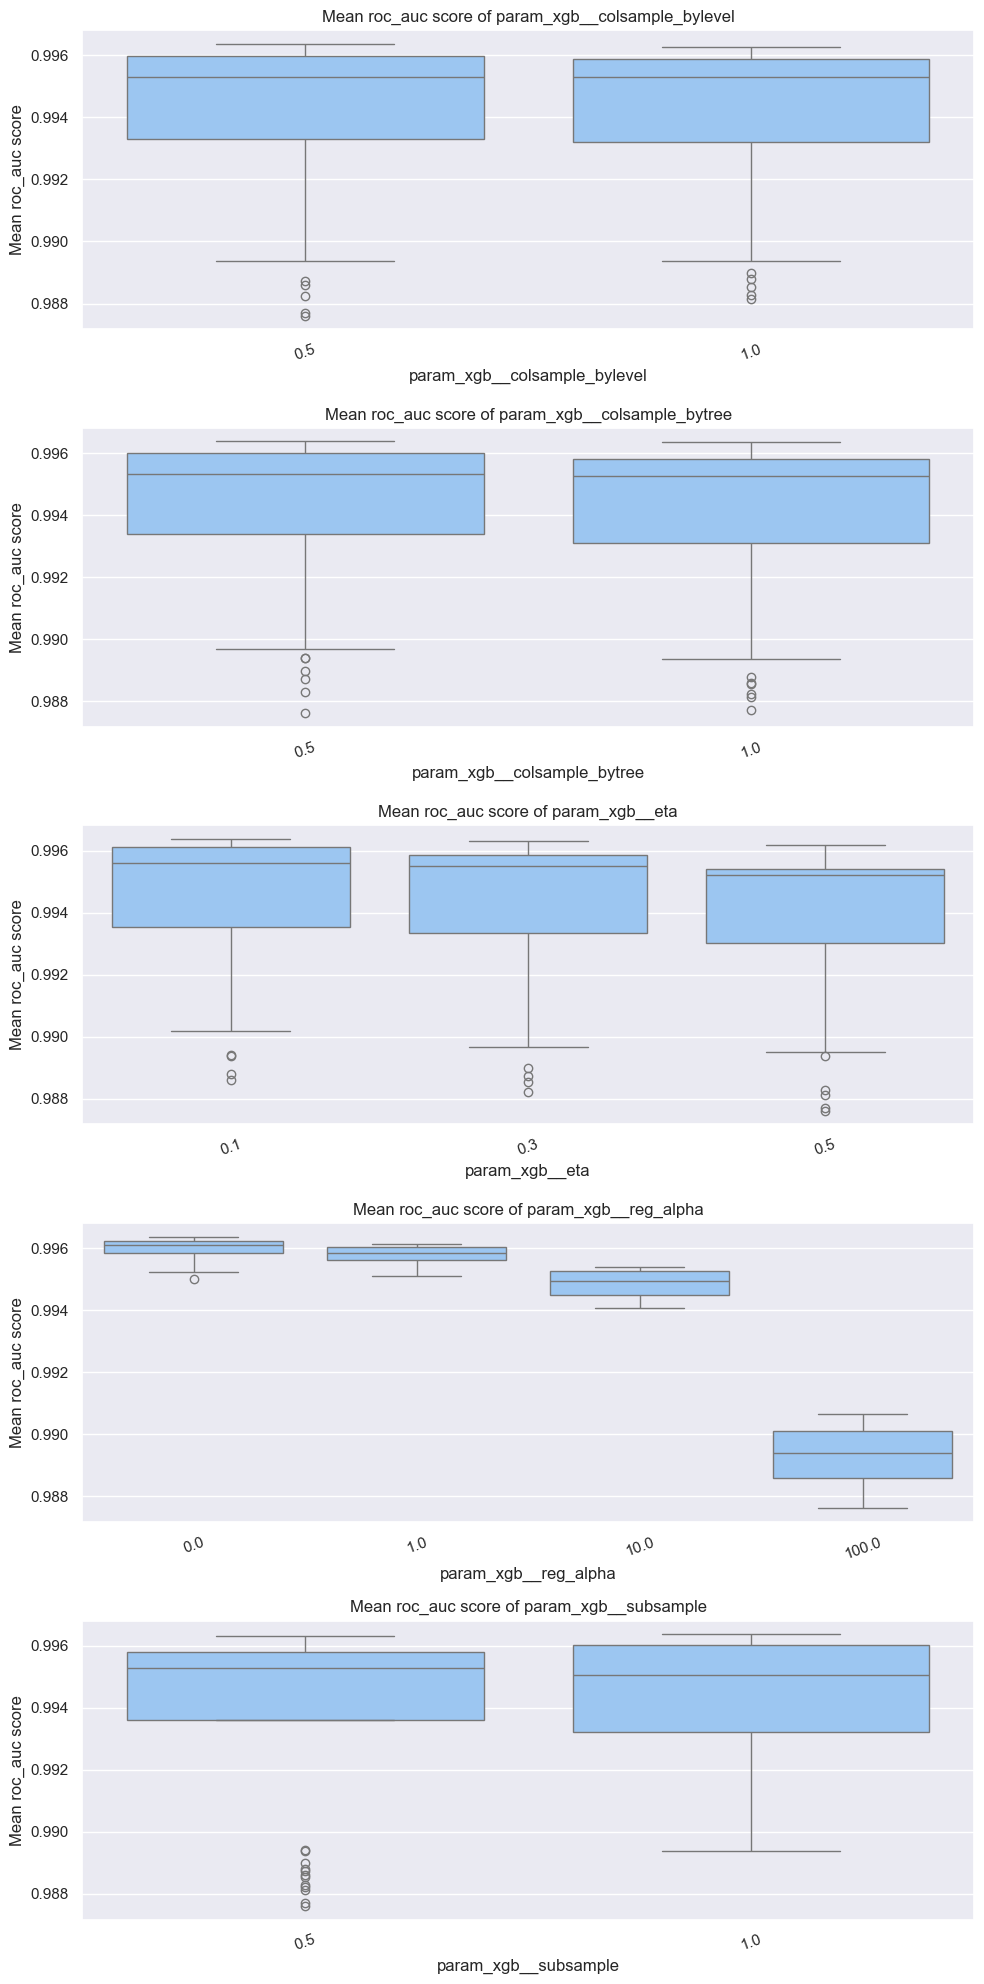


The training of MCF7_DropSeq is done, saving the model


----------------------------------------------------------------------------------------------------

Best roc_auc score: 0.9912360413335655

Cross-validation roc_auc scores: 0.9912360413335655

Cross-validation accuracy scores: 0.9587342131403432

Cross-validation f1 scores: 0.9480053582970197

Cross-validation precision scores: 0.9460074604901609

Cross-validation recall scores: 0.950035842293907


Parameters for the best model: 
{'xgb__colsample_bylevel': 0.5, 'xgb__colsample_bytree': 0.5, 'xgb__eta': 0.1, 'xgb__reg_alpha': 0.0, 'xgb__subsample': 0.5}


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Asus\AppData\Local\Temp\ipykernel_16744\16218594.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in t

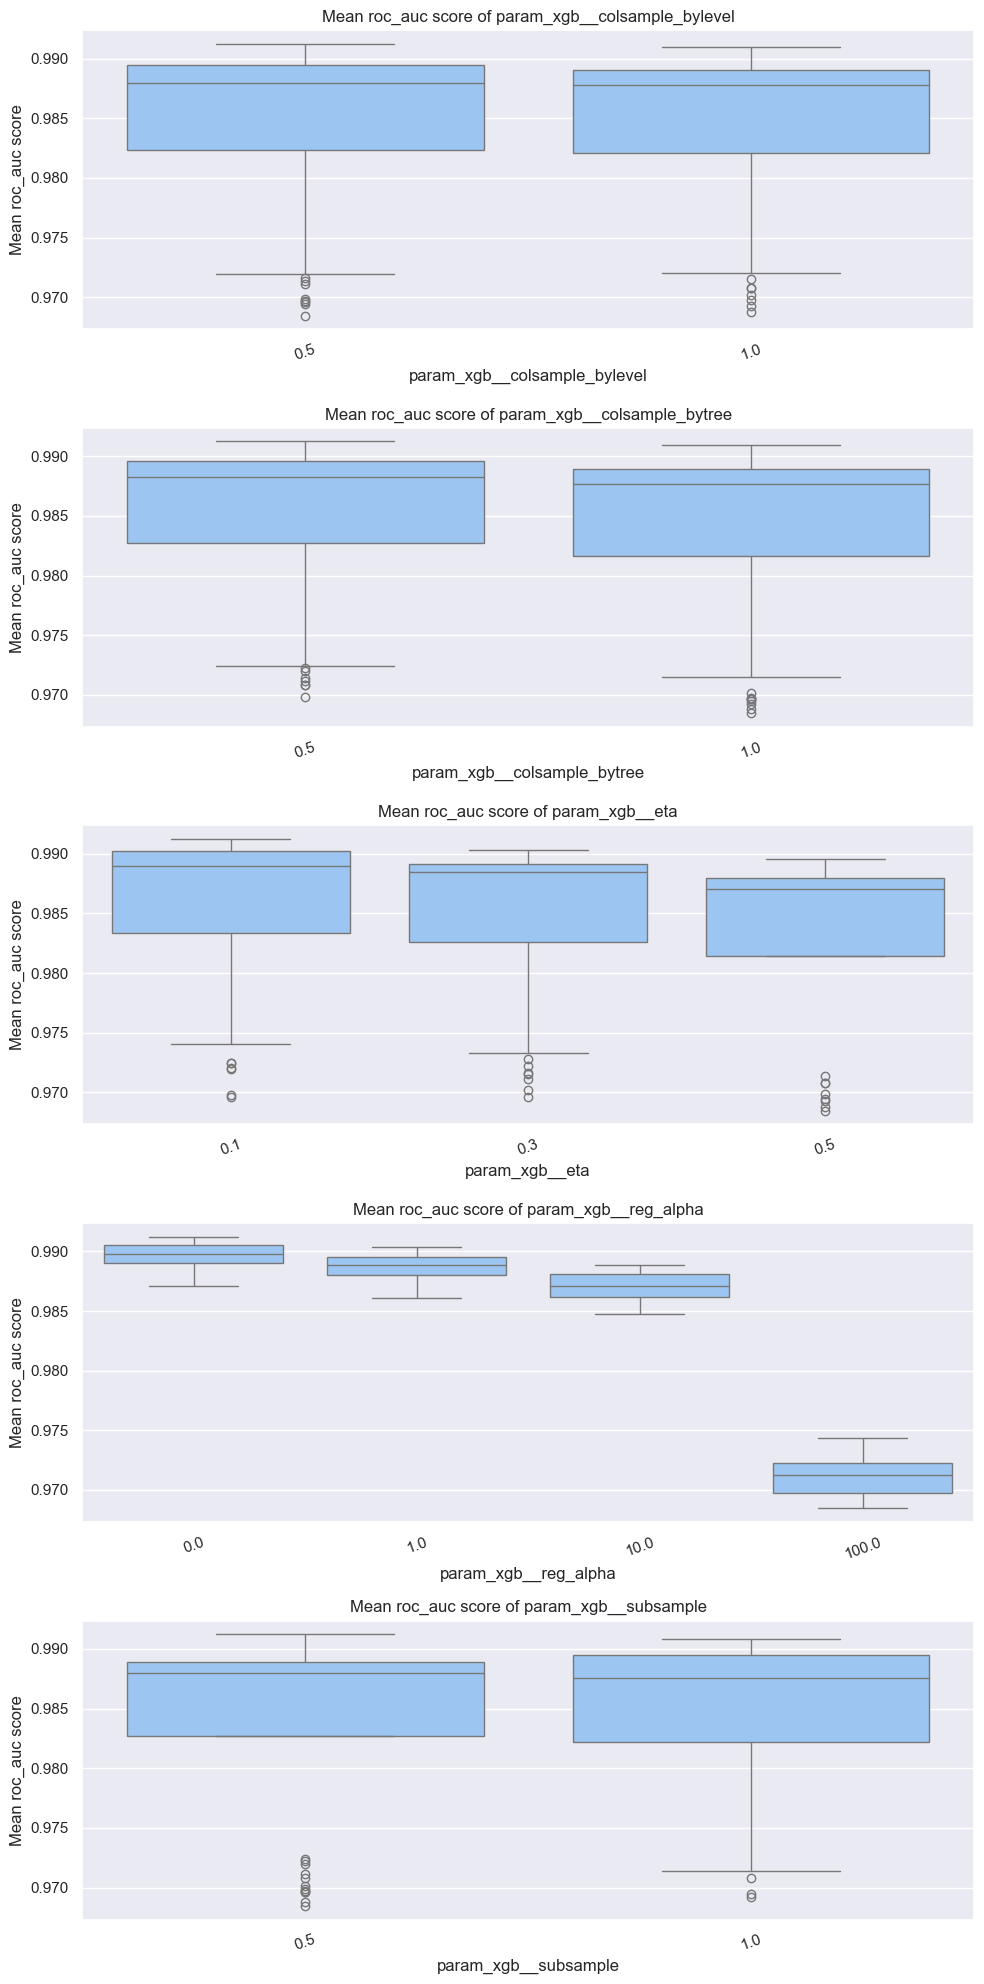


The training of HCC1806_DropSeq is done, saving the model


----------------------------------------------------------------------------------------------------


In [23]:
# Evaluate the models in their k-fold cross-validation
for name, df in datasets.items():
    with open(f'results/xgboost_mkII_result_{name}.pkl', 'rb') as f:
        result = pkl.load(f)
    model_validation_performance(result, probability=True)
    plot_results(result, principal_metric='roc_auc')
    print(f'\nThe training of {name} is done, saving the model\n\n')
    print('-'*100)

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Evaluating the performance on the test set for MCF7_SmartSeq:

ROC AUC: 1.0
Accuracy: 1.0
F1: 1.0
Precision: 1.0
Recall: 1.0


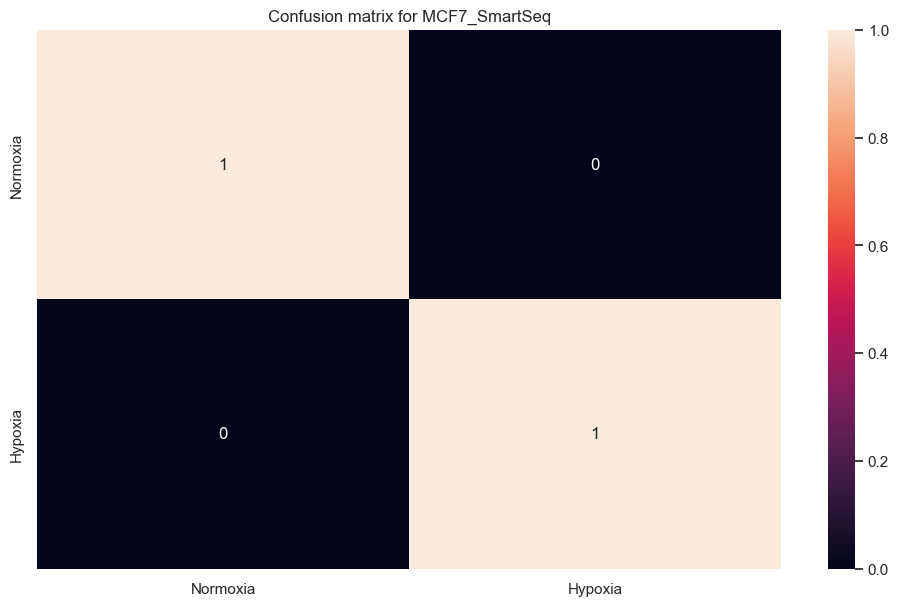

Evaluating the performance on the test set for HCC1806_SmartSeq:



c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ROC AUC: 1.0
Accuracy: 0.972972972972973
F1: 0.9714285714285714
Precision: 0.9444444444444444
Recall: 1.0


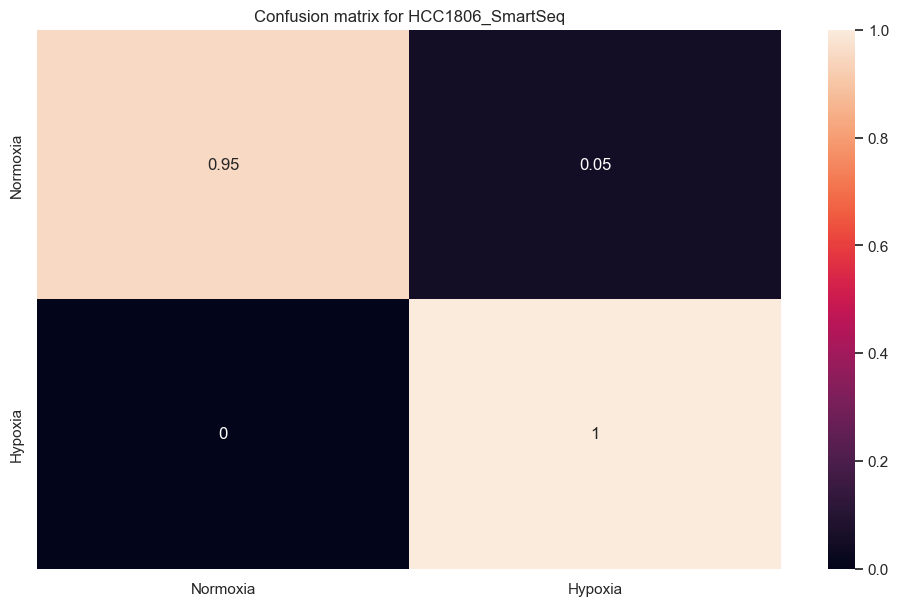

Evaluating the performance on the test set for MCF7_DropSeq:



c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ROC AUC: 0.9959449259427517
Accuracy: 0.9817383263985205
F1: 0.9845128406194863
Precision: 0.9858657243816255
Recall: 0.9831636648394675


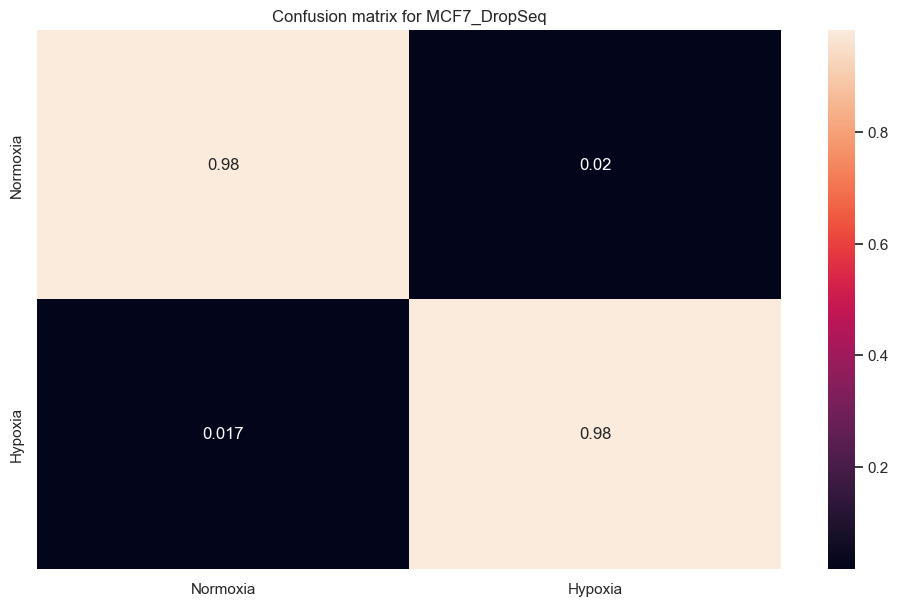

Evaluating the performance on the test set for HCC1806_DropSeq:



c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ROC AUC: 0.991657950272446
Accuracy: 0.961525366019748
F1: 0.9514813224559897
Precision: 0.9502572898799314
Recall: 0.9527085124677558


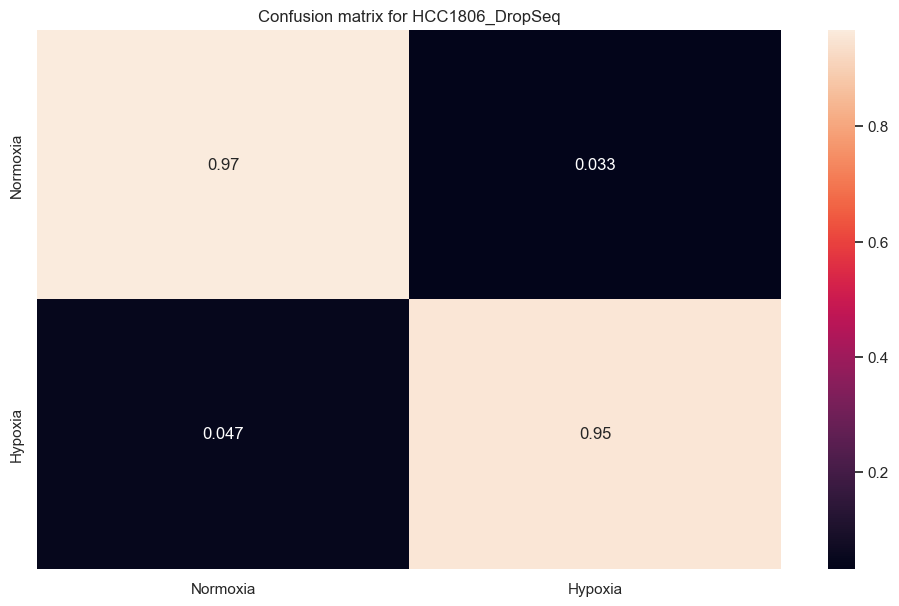

In [24]:
# Evaluating the best models
for name, df in datasets.items():
    # load the model
    model_name = f'xgboost_mkII_{name}'
    with open(f'models/{model_name}.pkl', 'rb') as f:
        best_model = pkl.load(f)
    
    model_test_performance(name, best_model, X_test[name], y_test[name])

&nbsp;

## RANDOM FOREST

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
def rf_pipe_params(X, y, n_estimators=200, balance=True):
    # Define the pipeline steps
    rf_pipeline = Pipeline([
        ('rf', RandomForestClassifier(class_weight='balanced', n_estimators=n_estimators, n_jobs=-1))  
    ])

    rf_params = {
        'rf__criterion': ['gini', 'entropy'],
        'rf__max_depth': [20, n_estimators*0.3, None],
        'rf__min_samples_split': [1, 5, 10],
        'rf__boostrap': [True, False]
    }
    return rf_pipeline, rf_params

In [ ]:
# Training the models
for name, df in datasets.items():
    print(f'Tuning {name} dataset')
    if (name == 'MCF7_SmartSeq') or (name == 'HCC1806_SmartSeq'):
        n_estimators = 100
    else:
        n_estimators = 1000
    pipeline, params = rf_pipe_params(X_train[name], y_train[name], n_estimators=n_estimators, balance=True)
    result, best_model = tune_model(X_train[name], y_train[name], params, pipeline, n_repeats=3, hyperparameter_tuner='grid', n_iter=100, verbose=10, probability=True, principal_metric='roc_auc', error_score=np.nan)

    # save the model and the result
    model_name = f'rf_{name}'
    with open(f'models/{model_name}.pkl', 'wb') as f:
        pkl.dump(best_model, f)

    result_name = f'rf_result_{name}'
    with open(f'results/{result_name}.pkl', 'wb') as f:
        pkl.dump(result, f)

In [26]:
# Evaluate the models in their k-fold cross-validation
for name, df in datasets.items():
    print(f'Validating ')
    with open(f'results/rf_result_{name}.pkl', 'rb') as f:
        result = pkl.load(f)
    model_validation_performance(result, probability=True)
    plot_results(result, principal_metric='roc_auc')
    print('-'*100)

Validating 


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your 

ValueError: node array from the pickle has an incompatible dtype:
- expected: [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]
- got     : {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}

In [ ]:
# Evaluating the best models
for name, df in datasets.items():
    # load the model
    model_name = f'rf_{name}'
    with open(f'models/{model_name}.pkl', 'rb') as f:
        best_model = pkl.load(f)
    
    model_test_performance(name, best_model, X_test[name], y_test[name])

In [22]:
with open(f'results/rf_result_HCC1806_DropSeq.pkl', 'rb') as f:
    g = pkl.load(f)

ValueError: node array from the pickle has an incompatible dtype:
- expected: [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]
- got     : {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}

&nbsp;

## SUPPORT VECTOR MACHINES

In [14]:
from sklearn.svm import SVC

In [15]:
def svm_pipe_params(X, y, balance=True):
    # Define the pipeline steps
    svm_pipeline = Pipeline([
        ('svm', SVC(class_weight='balanced'))  
    ])

    svm_params = {
        'svm__C': [0.1, 1, 10, 100],
        'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'svm__degree': [2, 5],
        'svm__gamma': ['scale', 'auto'],
        'svm__coef0': [0.0, 1.0]
    }
    return svm_pipeline, svm_params

In [16]:
for name, df in datasets.items():
    print(f'Tuning {name} dataset')
    pipeline, params = svm_pipe_params(X_train[name], y_train[name], balance=True)
    result, best_model = tune_model(X_train[name], y_train[name], params, pipeline, n_repeats=3, hyperparameter_tuner='grid', n_iter=100, verbose=10, probability=False, principal_metric='accuracy', error_score=np.nan)

    # save the model and the result
    model_name = f'svm_{name}'
    with open(f'models/{model_name}.pkl', 'wb') as f:
        pkl.dump(best_model, f)

    result_name = f'svm_result_{name}'
    with open(f'results/{result_name}.pkl', 'wb') as f:
        pkl.dump(result, f)

Tuning MCF7_SmartSeq dataset
Fitting 15 folds for each of 128 candidates, totalling 1920 fits
Tuning HCC1806_SmartSeq dataset
Fitting 15 folds for each of 128 candidates, totalling 1920 fits
Tuning MCF7_DropSeq dataset
Fitting 15 folds for each of 128 candidates, totalling 1920 fits


In [15]:
for name, df in datasets.items():
    with open(f'results/svm_result_{name}.pkl', 'rb') as f:
        result = pkl.load(f)
    model_validation_performance(result, probability=False, principal_metric='accuracy')
    print(f'\nThe training of {name} is done, saving the model\n\n')
    print('-'*100)


Best accuracy score: 1.0

Cross-validation accuracy scores: 1.0

Cross-validation f1 scores: 1.0

Cross-validation precision scores: 1.0

Cross-validation recall scores: 1.0


Parameters for the best model: 
{'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

The training of MCF7_SmartSeq is done, saving the model


----------------------------------------------------------------------------------------------------

Best accuracy score: 0.9793103448275862

Cross-validation accuracy scores: 0.9793103448275862

Cross-validation f1 scores: 0.9773358221174314

Cross-validation precision scores: 0.985982905982906

Cross-validation recall scores: 0.9699633699633701


Parameters for the best model: 
{'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

The training of HCC1806_SmartSeq is done, saving the model


----------------------------------------------------------------------------------------------------

Best accuracy score: 0.9789017341040461

Cross-validation accur

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info pleas

Evaluating the performance on the test set for MCF7_SmartSeq:

Accuracy: 0.98
F1: 0.9803921568627451
Precision: 0.9615384615384616
Recall: 1.0


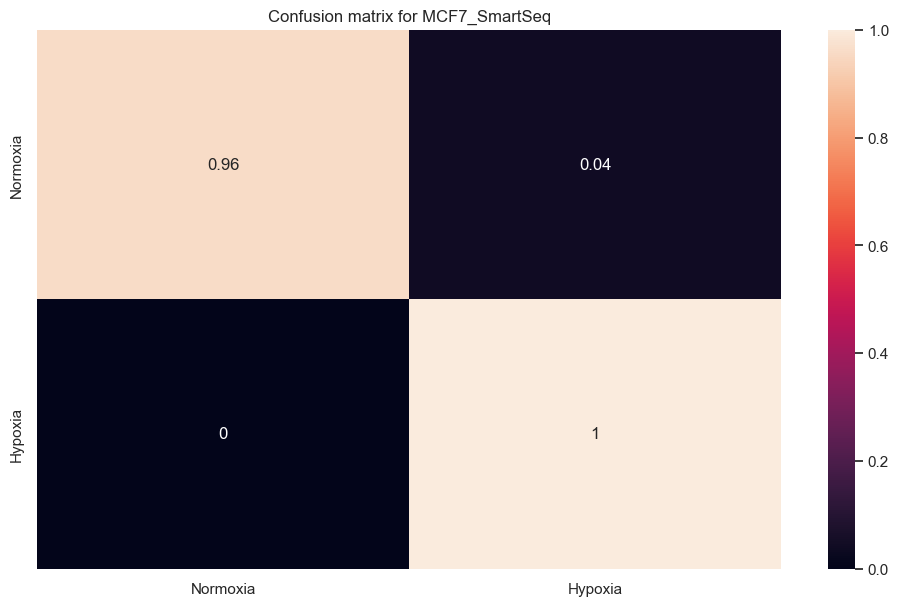

Evaluating the performance on the test set for HCC1806_SmartSeq:

Accuracy: 0.972972972972973
F1: 0.9714285714285714
Precision: 0.9444444444444444
Recall: 1.0


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


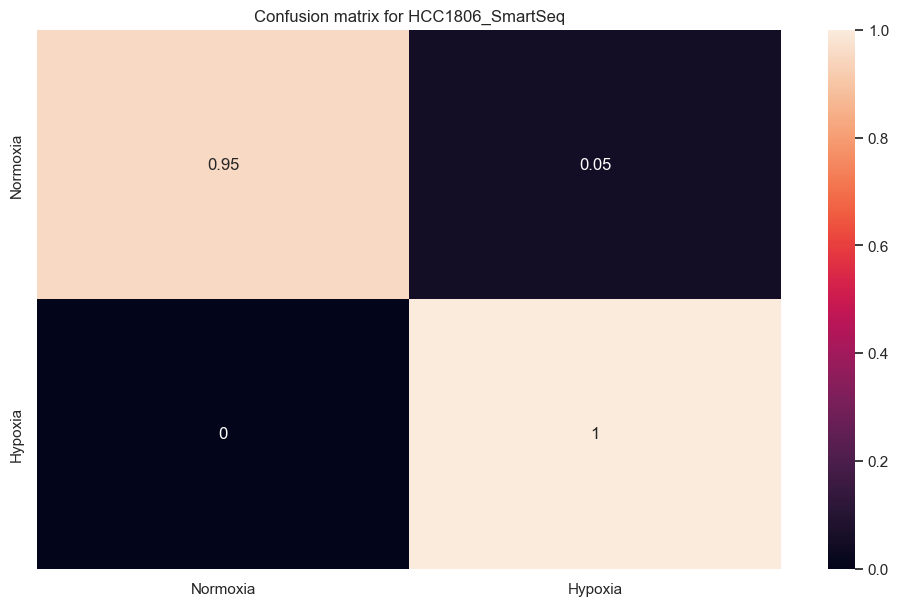

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Evaluating the performance on the test set for MCF7_DropSeq:

Accuracy: 0.9791955617198336
F1: 0.9823943661971831
Precision: 0.9816262705238468
Recall: 0.9831636648394675


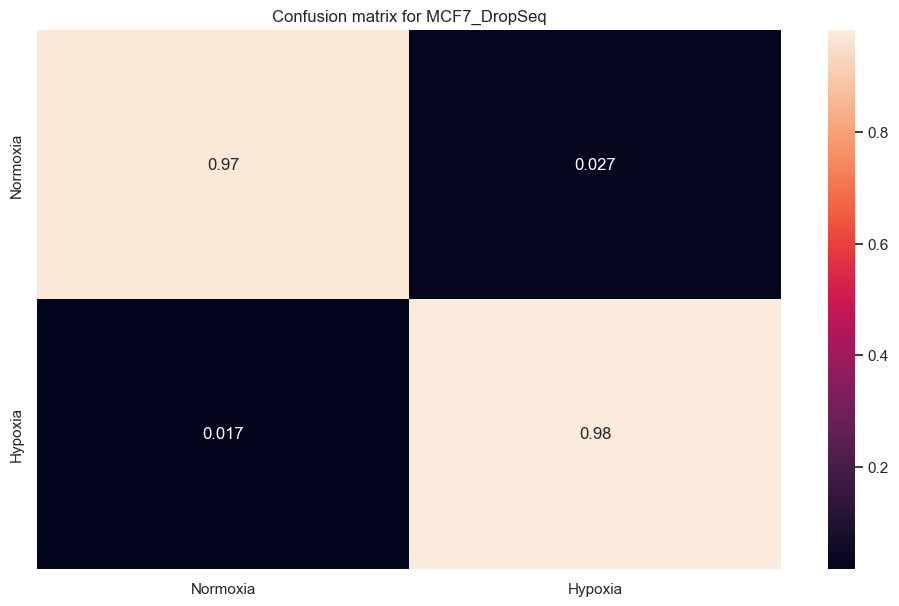

Evaluating the performance on the test set for HCC1806_DropSeq:



c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Accuracy: 0.9540347293156282
F1: 0.9417350021579628
Precision: 0.9454072790294628
Recall: 0.938091143594153


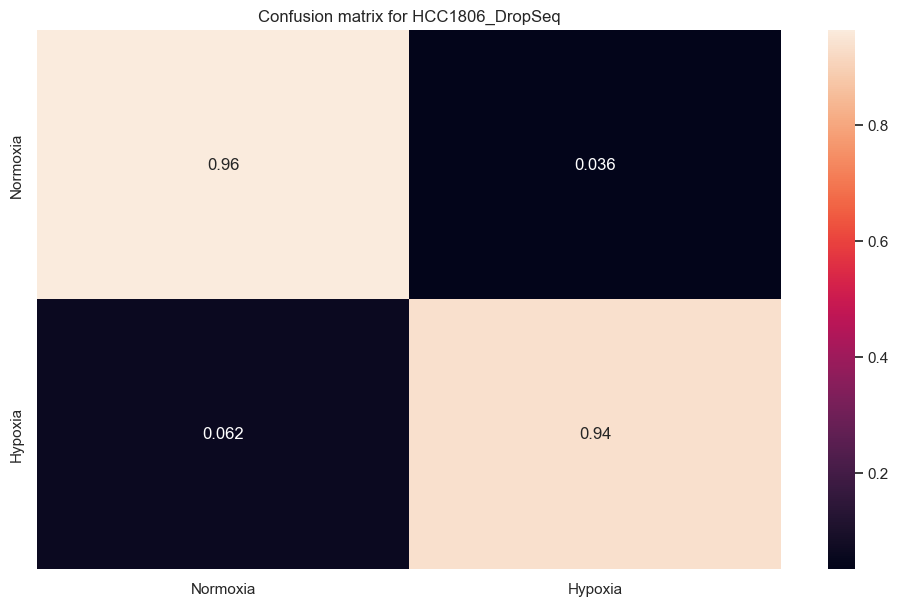

In [16]:
for name, df in datasets.items():
    # load the model
    model_name = f'svm_{name}'
    with open(f'models/{model_name}.pkl', 'rb') as f:
        best_model = pkl.load(f)
    
    model_test_performance(name, best_model, X_test[name], y_test[name], probability=False)

&nbsp;

## SGD CLASSIFIER

In [38]:
from sklearn.linear_model import SGDClassifier
import sklearn.metrics._scorer

In [35]:
def sgd_pipe_params(X, y, balance=True):
    # Define the pipeline steps
    sgd_pipeline = Pipeline([
        ('sgd', SGDClassifier(class_weight='balanced'))  
    ])

    sgd_params =[{
        'sgd__loss': ['hinge', 'log_loss', 'modified_huber'],
        'sgd__penalty': ['l2', 'l1'],
        'sgd__alpha': [0.001, 0.01, 0.1],
     },
    {
        'sgd__loss': ['hinge', 'log_loss', 'modified_huber'],
        'sgd__penalty': ['elasticnet'],
        'sgd__alpha': [0.001, 0.01, 0.1],
        'sgd__l1_ratio': [0.25, 0.5, 0.75]
    }]
    return sgd_pipeline, sgd_params

In [41]:
for name, df in datasets.items():
    print(f'Tuning {name} dataset')
    pipeline, params = sgd_pipe_params(X_train[name], y_train[name], balance=True)
    result, best_model = tune_model(X_train[name], y_train[name], params, pipeline, n_repeats=3, hyperparameter_tuner='grid', n_iter=100, verbose=10, probability=True, principal_metric='accuracy', error_score=np.nan)

    # save the model and the result
    model_name = f'sgd_{name}'
    with open(f'models/{model_name}.pkl', 'wb') as f:
        pkl.dump(best_model, f)

    result_name = f'sgd_result_{name}'
    with open(f'results/{result_name}.pkl', 'wb') as f:
        pkl.dump(result, f)

Tuning MCF7_SmartSeq dataset
Fitting 15 folds for each of 45 candidates, totalling 675 fits
Tuning HCC1806_SmartSeq dataset
Fitting 15 folds for each of 45 candidates, totalling 675 fits
Tuning MCF7_DropSeq dataset
Fitting 15 folds for each of 45 candidates, totalling 675 fits
Tuning HCC1806_DropSeq dataset
Fitting 15 folds for each of 45 candidates, totalling 675 fits


In [43]:
for name, df in datasets.items():
    with open(f'results/sgd_result_{name}.pkl', 'rb') as f:
        result = pkl.load(f)
    model_validation_performance(result, probability=False, principal_metric='accuracy')
    print(f'\nThe training of {name} is done, saving the model\n\n')
    print('-'*100)


Best accuracy score: 0.9983333333333333

Cross-validation accuracy scores: 0.9983333333333333

Cross-validation f1 scores: 0.9983739837398374

Cross-validation precision scores: 0.9968253968253968

Cross-validation recall scores: 1.0


Parameters for the best model: 
{'sgd__alpha': 0.001, 'sgd__loss': 'hinge', 'sgd__penalty': 'l1'}

The training of MCF7_SmartSeq is done, saving the model


----------------------------------------------------------------------------------------------------

Best accuracy score: 0.9701149425287354

Cross-validation accuracy scores: 0.9701149425287354

Cross-validation f1 scores: 0.969386177891925

Cross-validation precision scores: 0.9563492063492064

Cross-validation recall scores: 0.9857142857142858


Parameters for the best model: 
{'sgd__alpha': 0.01, 'sgd__l1_ratio': 0.5, 'sgd__loss': 'hinge', 'sgd__penalty': 'elasticnet'}

The training of HCC1806_SmartSeq is done, saving the model


-----------------------------------------------------------------

Evaluating the performance on the test set for MCF7_SmartSeq:

Accuracy: 1.0
F1: 1.0
Precision: 1.0
Recall: 1.0


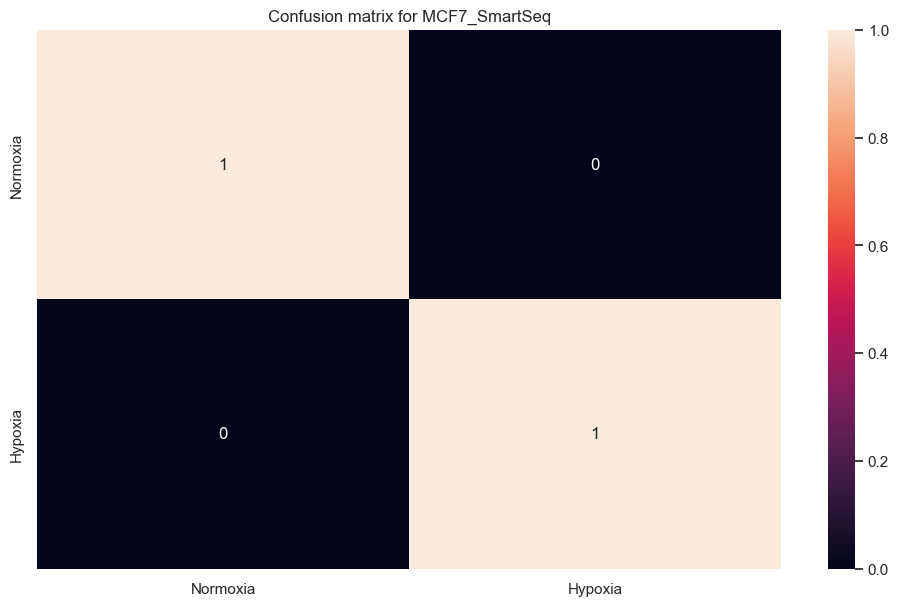

Evaluating the performance on the test set for HCC1806_SmartSeq:

Accuracy: 1.0
F1: 1.0
Precision: 1.0
Recall: 1.0


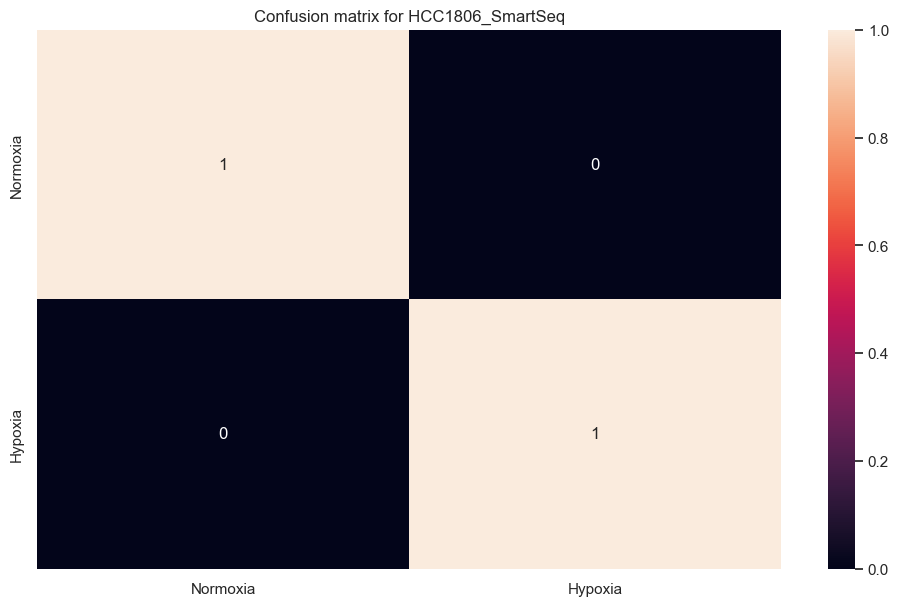

Evaluating the performance on the test set for MCF7_DropSeq:

Accuracy: 0.9699491447064262
F1: 0.9747180085569818
Precision: 0.9683153013910355
Recall: 0.9812059514487079


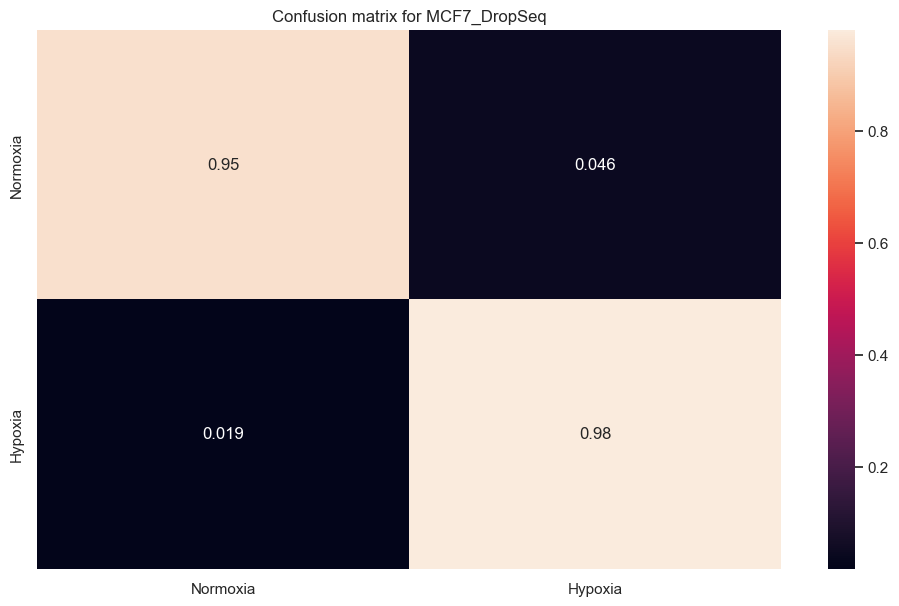

Evaluating the performance on the test set for HCC1806_DropSeq:

Accuracy: 0.9410963568266939
F1: 0.9275847634993721
Precision: 0.9037520391517129
Recall: 0.9527085124677558


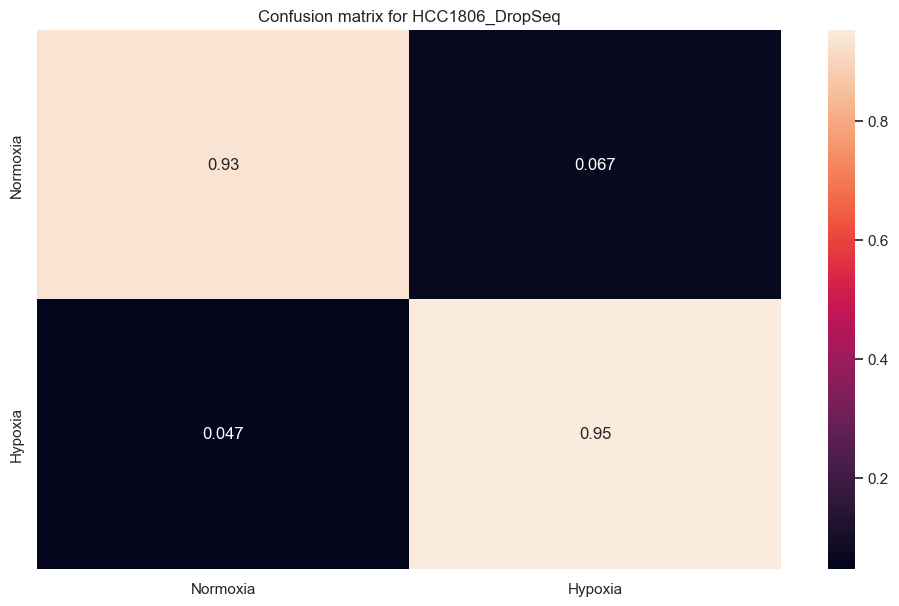

In [44]:
for name, df in datasets.items():
    # load the model
    model_name = f'sgd_{name}'
    with open(f'models/{model_name}.pkl', 'rb') as f:
        best_model = pkl.load(f)
    
    model_test_performance(name, best_model, X_test[name], y_test[name], probability=False)